# loading data

In [1]:
# import our libraries

#for manipulating our tables
import pandas as pd

#making plots
import matplotlib.pyplot as plt

#basic stats, t-tests
from scipy.stats import mannwhitneyu

from scipy.stats import fisher_exact

#math
import numpy as np

In [2]:
#load data that we extracted from SQL
covid_visits=pd.read_csv('../updated data/new_covid_visits.csv')
covid_all=pd.read_csv('../updated data/new_covid_all.csv')

In [3]:
#convert datetime fields into datetime format
covid_all['MEASUREMENT_DATETIME']=pd.to_datetime(covid_all['MEASUREMENT_DATETIME'])
covid_visits['VISIT_START_DATETIME']=pd.to_datetime(covid_visits['VISIT_START_DATETIME'])
covid_visits['VISIT_END_DATETIME']=pd.to_datetime(covid_visits['VISIT_END_DATETIME'])

In [4]:
covid_visits

,PERSON_ID,VISIT_OCCURRENCE_ID,VISIT_CONCEPT_ID,VISIT_START_DATETIME,VISIT_END_DATETIME
0,7703637957,100425603274,262,2020-04-10 20:13:00,2020-04-28 00:43:00
1,7703637957,100425787352,9202,2020-04-18 00:00:00,2020-04-18 00:00:00
2,7703637957,100426131739,42898160,2020-05-01 00:00:00,2020-05-01 00:00:00
3,7703637957,100428404927,9202,2020-07-05 00:00:00,2020-07-05 00:00:00
4,7703637957,100425604946,9202,2020-04-11 05:41:26,2020-04-11 05:41:26
...,...,...,...,...,...
3966662,9005891424,185027023368,42898160,2022-06-26 00:00:00,2022-06-26 00:00:00
3966663,9005891495,185027026194,9203,2022-06-26 18:48:00,2022-06-27 00:03:00
3966664,9005891495,185027028282,42898160,2022-06-26 00:00:00,2022-06-26 00:00:00
3966665,9005891674,185027050069,9203,2022-06-27 10:36:00,2022-06-27 14:20:00


In [5]:
covid_all

,PERSON_ID,VISIT_OCCURRENCE_ID,MEASUREMENT_DATETIME
0,9002523489,100436778670,2020-12-08 19:14:00
1,9001736039,100437707466,2020-12-31 10:20:00
2,7704501193,100439809624,2021-02-16 09:21:00
3,9000972138,100438038814,2021-01-08 00:16:00
4,9000849780,100439431946,2021-02-06 14:58:00
...,...,...,...
43953,9000820879,185022455565,2022-04-11 13:35:00
43954,9001110360,185025464989,2022-06-01 13:17:00
43955,9001622939,185022985557,2022-04-20 06:49:00
43956,9000565738,185025217042,2022-05-31 09:36:00


# flowchart

In [6]:
covid_all=covid_all.sort_values('MEASUREMENT_DATETIME',ascending=False).drop_duplicates('PERSON_ID',keep='last')

## Total covid sample size

In [7]:
#nunique tells us how many distinct items are in a series
covid_visits['PERSON_ID'].nunique()

38158

In [8]:
#pd.merge equivalent of a SQL join, it returns a new table
covid_combined=pd.merge(covid_all,covid_visits,on=['PERSON_ID','VISIT_OCCURRENCE_ID'],how='inner').drop_duplicates(['PERSON_ID'])

In [9]:
covid_combined

,PERSON_ID,VISIT_OCCURRENCE_ID,MEASUREMENT_DATETIME,VISIT_CONCEPT_ID,VISIT_START_DATETIME,VISIT_END_DATETIME
0,9002083220,185027108727,2022-06-27 21:57:00,9203,2022-06-27 22:10:00,2022-06-28 06:42:00
1,9002881381,185027108199,2022-06-27 21:45:00,9203,2022-06-27 20:59:00,2022-06-27 22:58:00
2,9003213255,185027107041,2022-06-27 20:48:00,9203,2022-06-27 19:41:00,2022-06-28 01:59:00
3,9000038307,185027076015,2022-06-27 20:25:00,9203,2022-06-27 14:11:00,2022-06-28 03:41:00
4,9000928761,185027107508,2022-06-27 20:17:00,9203,2022-06-27 20:22:00,2022-06-27 23:50:00
...,...,...,...,...,...,...
38145,9002395046,100424694916,2020-03-13 14:38:00,262,2020-03-13 13:41:00,2020-03-15 00:45:00
38146,9002056532,100424699963,2020-03-13 14:32:00,42898160,2020-03-13 00:00:00,2020-03-13 00:00:00
38147,9001633234,100424550518,2020-03-13 12:20:00,262,2020-03-11 11:03:00,2020-04-22 08:14:00
38148,9000077379,100424663743,2020-03-13 11:35:00,262,2020-03-13 08:19:00,2020-03-14 06:00:00


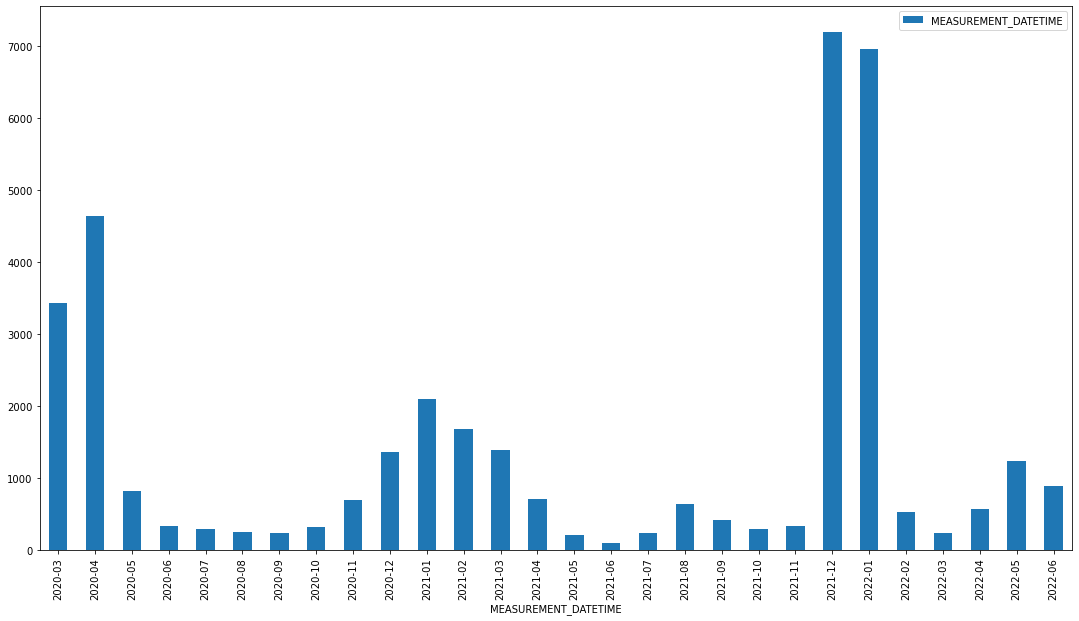

In [10]:
#graph of our covid data by measurement date
covid_combined[['MEASUREMENT_DATETIME']].groupby(covid_combined[['MEASUREMENT_DATETIME']]['MEASUREMENT_DATETIME'].dt.to_period('M')).count().plot(kind='bar')
fig=plt.gcf()
fig.set_size_inches(18.5,10)

## Hospitalized and Non-hospitalized split 

In [11]:
#these three concepts are our hospitalization concept IDs
hospitalized_concepts=[262,9201,32037]

In [12]:
#.isin will return a boolean, is the value in a list?
covid_hospitalized=covid_combined[covid_combined['VISIT_CONCEPT_ID'].isin(hospitalized_concepts)]

In [13]:
# ~ will negate the boolean, is the value not in a list?
covid_non_hospitalized=covid_combined[~covid_combined['VISIT_CONCEPT_ID'].isin(hospitalized_concepts)]

In [14]:
covid_hospitalized['PERSON_ID'].nunique()

12545

In [15]:
covid_non_hospitalized['PERSON_ID'].nunique()

25605

# table 1

## Demographics

In [16]:
#loading up data from another table
covid_demographics=pd.read_csv('../updated data/new_covid_person.csv')
covid_demographics['BIRTH_DATETIME']=pd.to_datetime(covid_demographics['BIRTH_DATETIME'])

In [17]:
covid_demographics

,PERSON_ID,BIRTH_DATETIME,DEATH_DATETIME,GENDER_SOURCE_VALUE,RACE_SOURCE_VALUE,ETHNICITY_SOURCE_VALUE
0,7703637957,1953-03-28,2020-04-28 00:43:00,Male,R5 White,E2 Not Spanish/Hispanic/Latino
1,7703644966,1971-12-23,NaN,Male,R9 Other,E2 Not Spanish/Hispanic/Latino
2,7703653281,1985-10-21,NaN,Male,R2 Asian,E2 Not Spanish/Hispanic/Latino
3,7703658658,1978-09-23,NaN,Female,R2 Asian,E2 Not Spanish/Hispanic/Latino
4,7703658698,1947-09-15,NaN,Male,R9 Other,E2 Not Spanish/Hispanic/Latino
...,...,...,...,...,...,...
38153,9005891395,2001-06-12,NaN,Male,R9 Other,E2 Not Spanish/Hispanic/Latino
38154,9005891424,1975-08-04,NaN,Male,R9 Other,E1 Spanish/Hispanic/Latino
38155,9005891495,2022-05-11,NaN,Female,R2 Asian,E2 Not Spanish/Hispanic/Latino
38156,9005891674,2017-03-22,NaN,Female,R9 Other,E1 Spanish/Hispanic/Latino


In [18]:
covid_hosp_demo=pd.merge(covid_hospitalized,covid_demographics,on=['PERSON_ID'])
covid_non_hosp_demo=pd.merge(covid_non_hospitalized,covid_demographics,on=['PERSON_ID'])

## Average age

In [19]:
#average age, we want base line characteristics so do it by date of covid
hosp_ages=((covid_hosp_demo['MEASUREMENT_DATETIME']-covid_hosp_demo['BIRTH_DATETIME']).dt.days/365.25)
print(hosp_ages.mean(),hosp_ages.std())

61.45158273473542 20.29831634812566


In [20]:
non_hosp_ages=((covid_non_hosp_demo['MEASUREMENT_DATETIME']-covid_non_hosp_demo['BIRTH_DATETIME']).dt.days/365.25)
print(non_hosp_ages.mean(),non_hosp_ages.std())

40.32326559678793 20.82574175932183


## CKD

In [21]:
covid_conditions=pd.read_csv('../updated data/new_covid_conditions.csv')

In [22]:
CKD_ID=[45582391, 45582392, 45553437, 45543858, 45582393, 45582394, 45553438, 46271022, 443597, 44782429, 443612, 443601, 45768812, 443611, 44784621, 46271022, 443614, 44782691, 44782728, 37017104, 43531653, 43531577, 45757446]

In [23]:
covid_CKD=covid_conditions[covid_conditions['CONDITION_CONCEPT_ID'].isin(CKD_ID)]

covid_hosp_CKD=pd.merge(covid_hospitalized,covid_CKD,on=['PERSON_ID'])
covid_non_hosp_CKD=pd.merge(covid_non_hospitalized,covid_CKD,on=['PERSON_ID'])

In [24]:
#by using a boolean expression inside [] you can filter the rows that you want
cnt_hosp=covid_hosp_CKD[covid_hosp_CKD['CONDITION_START_DATETIME']<covid_hosp_CKD['MEASUREMENT_DATETIME']]['PERSON_ID'].nunique()
print(cnt_hosp,round(cnt_hosp/covid_hospitalized['PERSON_ID'].nunique()*100,2))

2132 16.99


In [25]:
cnt_non_hosp=covid_non_hosp_CKD[covid_non_hosp_CKD['CONDITION_START_DATETIME']<covid_non_hosp_CKD['MEASUREMENT_DATETIME']]['PERSON_ID'].nunique()
print(cnt_non_hosp,round(cnt_non_hosp/covid_non_hospitalized['PERSON_ID'].nunique()*100,2))

911 3.56


In [26]:
cnt_all=cnt_hosp+cnt_non_hosp
print(cnt_all,round(cnt_all/covid_combined['PERSON_ID'].nunique()*100,2))

3043 7.98


## BMI

In [27]:
lab_vals_all=pd.read_csv('../updated data/new_covid_lab_vals.csv')
lab_vals_all['MEASUREMENT_DATETIME']=pd.to_datetime(lab_vals_all['MEASUREMENT_DATETIME'])

In [28]:
lab_vals_all=lab_vals_all[lab_vals_all['MEASUREMENT_CONCEPT_ID'].isin([3038553])]

In [29]:
lab_vals_all['UNIT_SOURCE_VALUE'].unique()

array(['kg/m2'], dtype=object)

In [30]:
covid_hosp_BMI=pd.merge(covid_hospitalized,lab_vals_all,on=['PERSON_ID'],how='inner').rename({'MEASUREMENT_DATETIME_x': 'MEASUREMENT_DATETIME_COVID','MEASUREMENT_DATETIME_y': 'MEASUREMENT_DATETIME_BMI'},axis='columns')
covid_non_hosp_BMI=pd.merge(covid_non_hospitalized,lab_vals_all,on=['PERSON_ID'],how='inner').rename({'MEASUREMENT_DATETIME_x': 'MEASUREMENT_DATETIME_COVID','MEASUREMENT_DATETIME_y': 'MEASUREMENT_DATETIME_BMI'},axis='columns')

In [31]:
covid_hosp_BMI

,PERSON_ID,VISIT_OCCURRENCE_ID,MEASUREMENT_DATETIME_COVID,VISIT_CONCEPT_ID,VISIT_START_DATETIME,VISIT_END_DATETIME,MEASUREMENT_DATETIME_BMI,MEASUREMENT_CONCEPT_ID,VALUE_AS_NUMBER,UNIT_SOURCE_VALUE
0,9001868725,185027105870,2022-06-27 19:00:00,262,2022-06-27 18:47:00,NaT,2016-07-13 19:03:00,3038553,31.5,kg/m2
1,9001868725,185027105870,2022-06-27 19:00:00,262,2022-06-27 18:47:00,NaT,2016-10-19 12:57:00,3038553,31.6,kg/m2
2,9001868725,185027105870,2022-06-27 19:00:00,262,2022-06-27 18:47:00,NaT,2016-12-27 15:04:00,3038553,32.0,kg/m2
3,9001868725,185027105870,2022-06-27 19:00:00,262,2022-06-27 18:47:00,NaT,2017-12-13 13:25:00,3038553,32.7,kg/m2
4,9001868725,185027105870,2022-06-27 19:00:00,262,2022-06-27 18:47:00,NaT,2017-12-29 11:48:00,3038553,32.1,kg/m2
...,...,...,...,...,...,...,...,...,...,...
172866,9000077379,100424663743,2020-03-13 11:35:00,262,2020-03-13 08:19:00,2020-03-14 06:00:00,2020-06-05 14:15:00,3038553,33.7,kg/m2
172867,9000077379,100424663743,2020-03-13 11:35:00,262,2020-03-13 08:19:00,2020-03-14 06:00:00,2020-12-10 13:59:00,3038553,33.9,kg/m2
172868,9000077379,100424663743,2020-03-13 11:35:00,262,2020-03-13 08:19:00,2020-03-14 06:00:00,2020-12-11 10:35:00,3038553,34.2,kg/m2
172869,9000077379,100424663743,2020-03-13 11:35:00,262,2020-03-13 08:19:00,2020-03-14 06:00:00,2022-01-19 08:29:00,3038553,31.0,kg/m2


In [32]:
covid_hosp_BMI=covid_hosp_BMI[(covid_hosp_BMI['MEASUREMENT_DATETIME_BMI']>=covid_hosp_BMI['VISIT_START_DATETIME'])&(covid_hosp_BMI['MEASUREMENT_DATETIME_BMI']<=covid_hosp_BMI['VISIT_START_DATETIME']+pd.DateOffset(days=1))]

In [33]:
covid_hosp_BMI=covid_hosp_BMI.sort_values(['MEASUREMENT_DATETIME_BMI']).drop_duplicates(['PERSON_ID'],keep='first')
covid_non_hosp_BMI=covid_non_hosp_BMI.sort_values(['MEASUREMENT_DATETIME_BMI']).drop_duplicates(['PERSON_ID'],keep='first')

In [34]:
def drop_outlier(vals):
    std=np.std(vals)
    mean=np.mean(vals)
    return [v for v in vals if v>=mean-2*std and v <=mean+2*std]

In [35]:
hosp_bmi=drop_outlier(list(covid_hosp_BMI['VALUE_AS_NUMBER'].dropna()))
print(np.mean(hosp_bmi),np.std(hosp_bmi))

29.435490605427972 8.684493907090653


In [36]:
non_hosp_bmi=drop_outlier(list(covid_non_hosp_BMI['VALUE_AS_NUMBER'].dropna()))
print(np.mean(non_hosp_bmi),np.std(non_hosp_bmi))

27.746085782843434 8.364269542216157


# Stats

In [37]:
mannwhitneyu(hosp_ages,non_hosp_ages)[1]

0.0

In [38]:
fisher_exact([
    [cnt_hosp,cnt_non_hosp],
    [len(covid_hospitalized.index)-cnt_hosp,len(covid_non_hospitalized.index)-cnt_non_hosp],
])[1]

0.0

In [39]:
mannwhitneyu(hosp_bmi,non_hosp_bmi)[1]

5.710389569718311e-37